In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Generate synthetic data
np.random.seed(42)
data_size = 1000
payment_history = np.random.normal(0.5, 1, data_size)
credit_utilization = np.random.uniform(0.3, 0.9, data_size)
credit_history_length = np.random.normal(0.5, 1, data_size)
total_accounts = np.random.uniform(0.1, 1, data_size)
credit_score = (0.4 * payment_history + 0.4 * credit_utilization + 0.2 * credit_history_length + 0.1 * total_accounts) * 900
default = np.random.choice([0, 1], size=(data_size,), p=[0.8, 0.2])

df = pd.DataFrame({
    'Payment History': payment_history,
    'Credit Utilization': credit_utilization,
    'Credit History Length': credit_history_length,
    'Total Accounts': total_accounts,
    'Credit Score': credit_score,
    'Default': default
})

# Features and target variable
X = df[['Payment History', 'Credit Utilization', 'Credit History Length', 'Total Accounts', 'Credit Score']]
y = df['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
class PDModel:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.y_pred = None
        self.y_prob = None

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        self.y_prob = self.model.predict_proba(X_test)[:, 1]

    def evaluate_model(self, y_true):
        accuracy = accuracy_score(y_true, self.y_pred)
        # Calculate precision, recall, and f1 only if there are positive predictions
        if np.sum(self.y_pred == 1) > 0:
            precision = precision_score(y_true, self.y_pred)
            recall = recall_score(y_true, self.y_pred)
            f1 = f1_score(y_true, self.y_pred)
        else:
            precision, recall, f1 = 0, 0, 0
        roc_auc = roc_auc_score(y_true, self.y_prob)

        print(f"\nModel: {self.model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    def plot_roc_curve(self, y_true):
        fpr, tpr, _ = roc_curve(y_true, self.y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{self.model_name} (AUC = {roc_auc_score(y_true, self.y_prob):.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, y_true):
        cm = confusion_matrix(y_true, self.y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f'Confusion Matrix - {self.model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [22]:
class CreditScorePDModel:
    def __init__(self):
        self.mean_defaults = {}
        self.y_pred = None
        self.y_prob = None
        self.model_name = 'Credit Score PD Model'

    def train_model(self, X_train, y_train):
        df = X_train.copy()
        df['Default'] = y_train
        grouped_data = df.groupby('Credit Score')['Default'].mean()
        self.mean_defaults = grouped_data.to_dict()

    def predict_proba(self, X):
        x_values = X['Credit Score']
        prob_default = np.array([self.mean_defaults.get(score, 0) for score in x_values])
        self.y_prob = prob_default
        self.y_pred = np.where(prob_default >= 0.5, 1, 0)
        return prob_default

    def evaluate_model(self, y_true):
        accuracy = np.mean(self.y_pred == y_true)
        precision = np.sum((self.y_pred == 1) & (y_true == 1)) / np.sum(self.y_pred == 1) if np.sum(self.y_pred == 1) > 0 else 0
        recall = np.sum((self.y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
        f1 = 2 * (precision * recall) / (precision + recall)
        roc_auc = roc_auc_score(y_true, self.y_prob)

        print(f"\nModel: {self.model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    def plot_roc_curve(self, y_true):
        fpr, tpr, _ = roc_curve(y_true, self.y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{self.model_name} (AUC = {roc_auc_score(y_true, self.y_prob):.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()


Model: Logistic Regression
Accuracy: 0.8100
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.4675


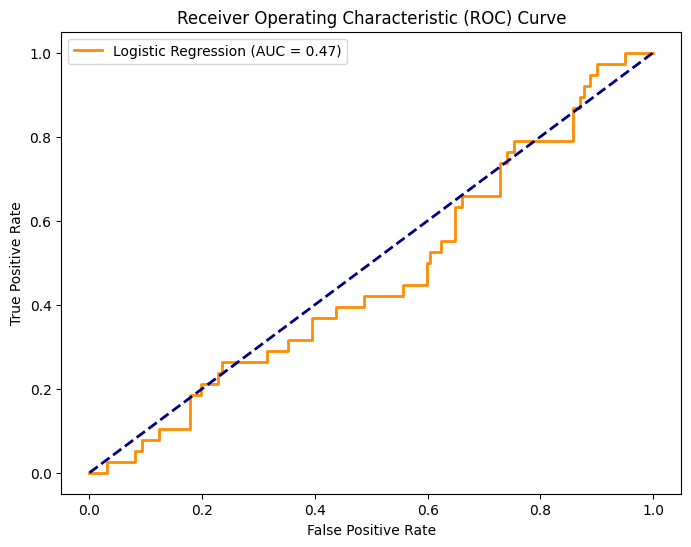

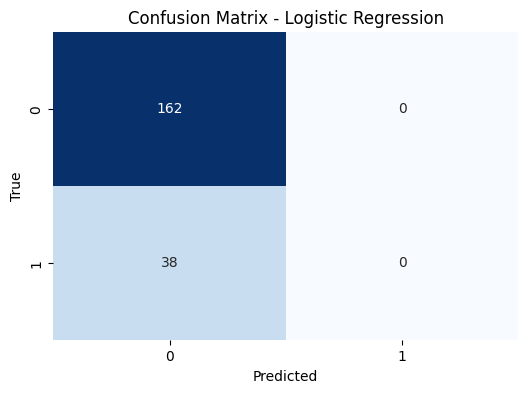

In [23]:
# Create and train models
logreg_model = LogisticRegression()
dt_model = DecisionTreeClassifier(random_state=42)
credit_score_pd_model = CreditScorePDModel()

logreg_pd_model = PDModel(logreg_model, 'Logistic Regression')
dt_pd_model = PDModel(dt_model, 'Decision Tree')

# Train and evaluate Logistic Regression model
logreg_pd_model.train_model(X_train, y_train)
logreg_pd_model.predict(X_test)
logreg_pd_model.evaluate_model(y_test)
logreg_pd_model.plot_roc_curve(y_test)
logreg_pd_model.plot_confusion_matrix(y_test)


Model: Decision Tree
Accuracy: 0.6600
Precision: 0.1591
Recall: 0.1842
F1 Score: 0.1707
ROC AUC: 0.4779


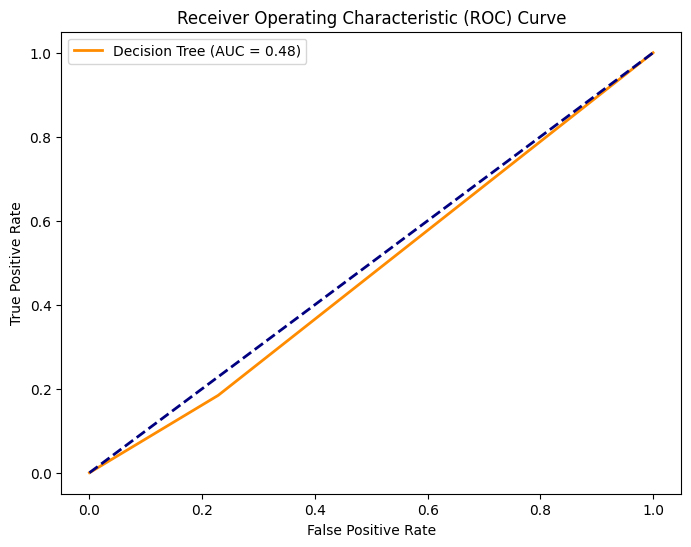

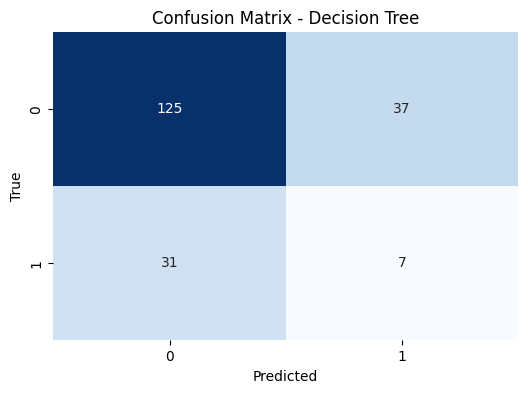

In [24]:
# Train and evaluate Decision Tree model
dt_pd_model.train_model(X_train, y_train)
dt_pd_model.predict(X_test)
dt_pd_model.evaluate_model(y_test)
dt_pd_model.plot_roc_curve(y_test)
dt_pd_model.plot_confusion_matrix(y_test)

/tmp/ipykernel_43/2911966230.py:25: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)



Model: Credit Score PD Model
Accuracy: 0.8100
Precision: 0.0000
Recall: 0.0000
F1 Score: nan
ROC AUC: 0.5000


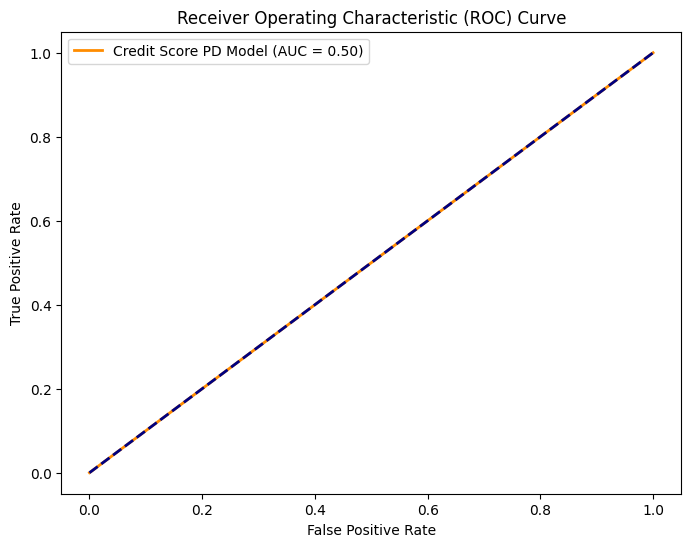

In [25]:
# Train and evaluate Credit Score PD Model
credit_score_pd_model = CreditScorePDModel()
credit_score_pd_model.train_model(X_train, y_train)

# Predict probabilities on the test set
credit_score_pd_model.predict_proba(X_test)

# Evaluate the model
credit_score_pd_model.evaluate_model(y_test)

# Plot ROC curve
credit_score_pd_model.plot_roc_curve(y_test)

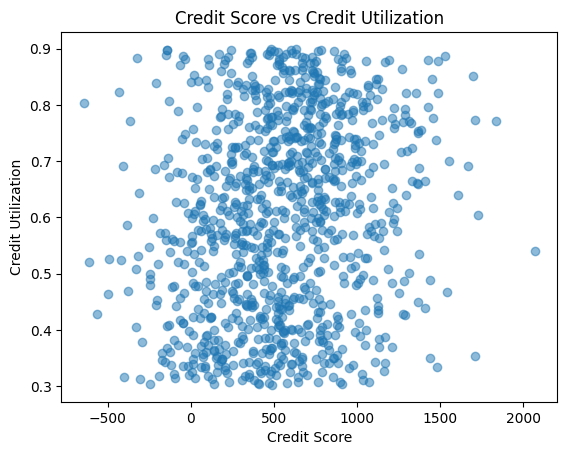

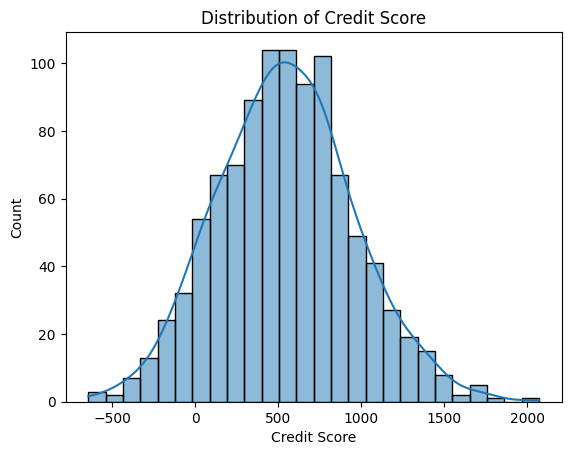

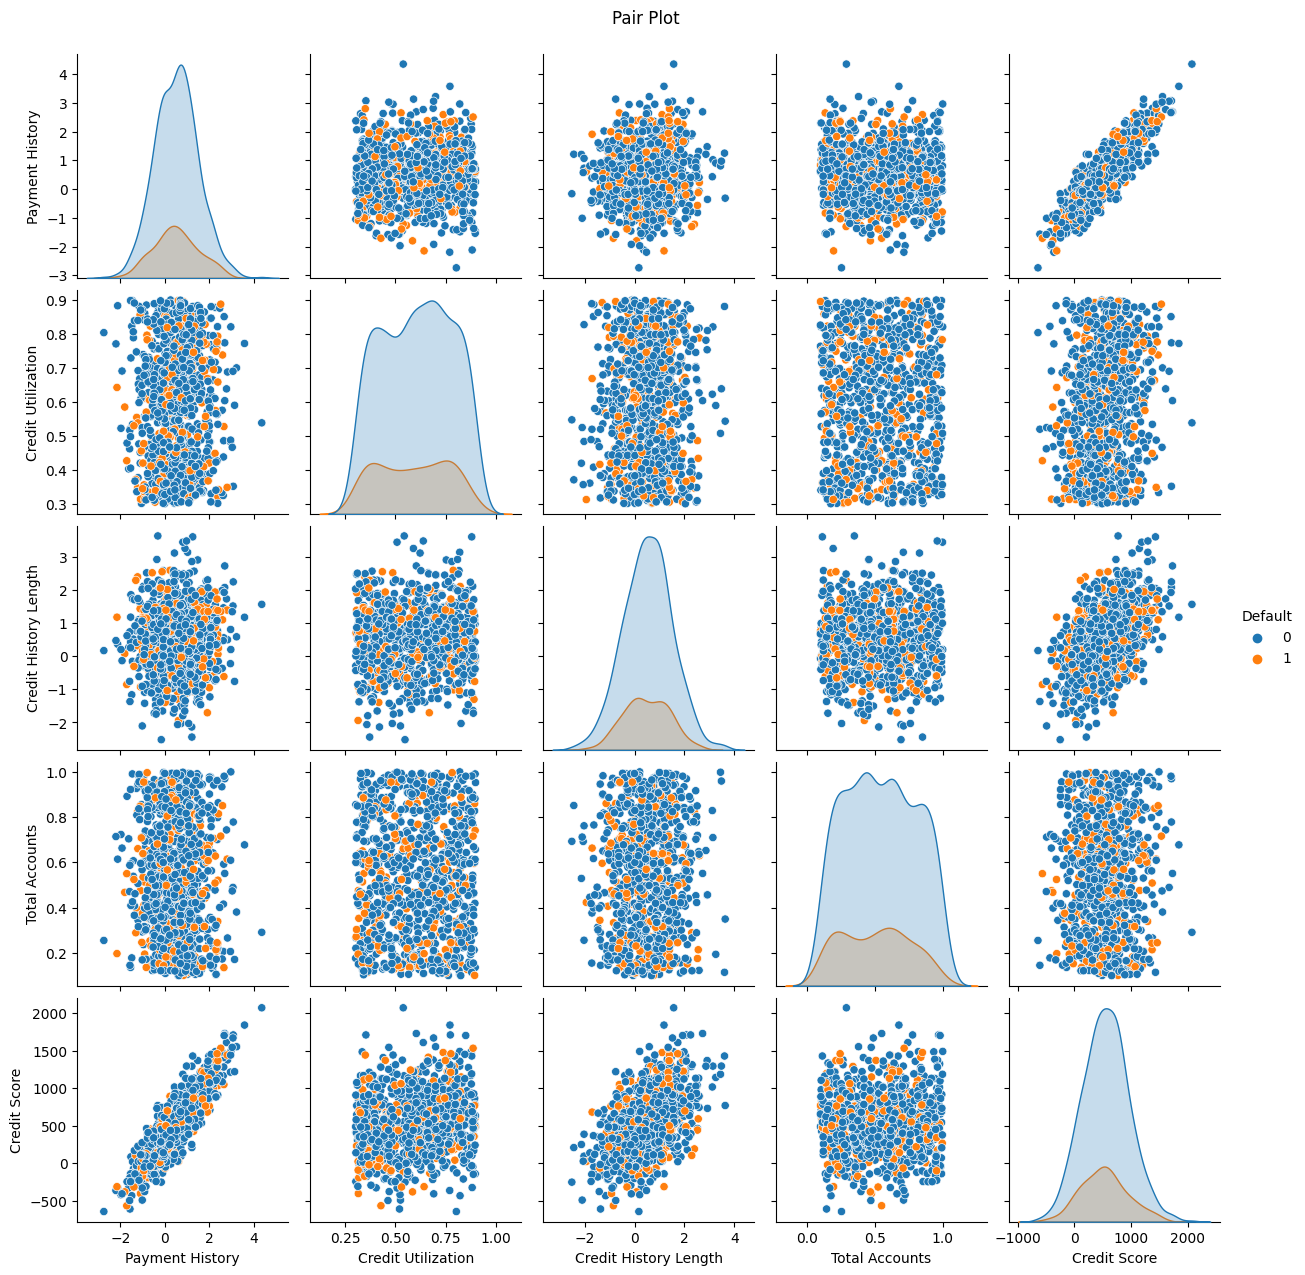

In [26]:
# Visualizations
def plot_scatter(x, y, title, xlabel, ylabel):
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_distribution(data, title, xlabel):
    sns.histplot(data, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

def plot_pair_plot(data, hue, title):
    sns.pairplot(data, hue=hue)
    plt.suptitle(title, y=1.02)
    plt.show()

# Scatter Plot
plot_scatter(df['Credit Score'], df['Credit Utilization'], 'Credit Score vs Credit Utilization', 'Credit Score', 'Credit Utilization')

# Distribution Plot
plot_distribution(df['Credit Score'], 'Distribution of Credit Score', 'Credit Score')

# Pair Plot
plot_pair_plot(df, hue='Default', title='Pair Plot')